                                      image_path          label
0   PlantVillage\Apple___healthy\image (533).JPG  apple-healthy
1  PlantVillage\Apple___healthy\image (1451).JPG  apple-healthy
2   PlantVillage\Apple___healthy\image (129).JPG  apple-healthy
3  PlantVillage\Apple___healthy\image (1384).JPG  apple-healthy
4   PlantVillage\Apple___healthy\image (555).JPG  apple-healthy


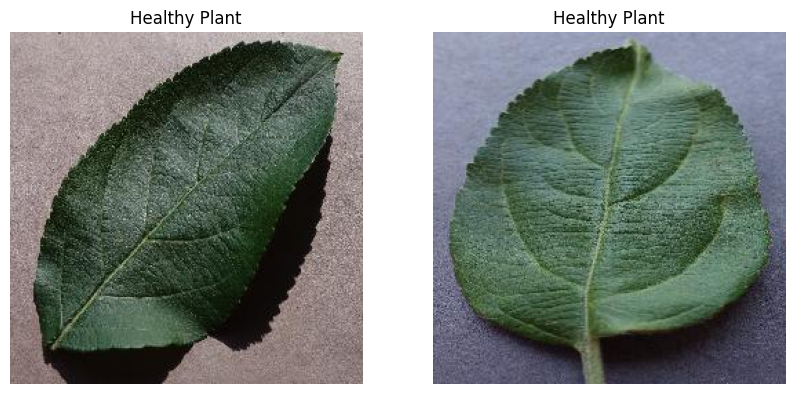

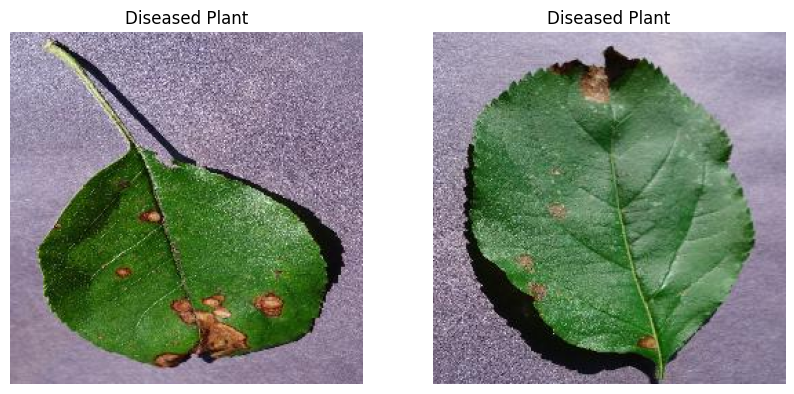

In [1]:
# Importing necessary libraries
import os
import random
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt


extract_path = "PlantVillage"

# Define paths for the two classes
class1 = 'Apple___healthy'
class2 = 'Apple___Black_rot'

# Define the directories
class1_dir = os.path.join(extract_path, class1)
class2_dir = os.path.join(extract_path, class2)

# Get a list of image files in each class directory
class1_images = [os.path.join(class1_dir, img) for img in os.listdir(class1_dir) if img.endswith(('.JPG', '.jpg', '.png'))]
class2_images = [os.path.join(class2_dir, img) for img in os.listdir(class2_dir) if img.endswith(('.JPG', '.jpg', '.png'))]

# Randomly sample 100 images from each class
sample_size = 100
class1_sample = random.sample(class1_images, sample_size)
class2_sample = random.sample(class2_images, sample_size)

# Create a DataFrame to store the samples and their labels
data = {'image_path': class1_sample + class2_sample, 
        'label': ['apple-healthy']*sample_size + ['apple-black-rot']*sample_size}

df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())

# Displaying the first two images from healthy plants and the last two from diseased plants
healthy_sample = class1_sample[:2]
diseased_sample = class2_sample[-2:]

# Function to display images
def display_images(image_paths, title):
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        plt.subplot(1, len(image_paths), i+1)
        plt.imshow(img)
        plt.title(title[i])
        plt.axis('off')
    plt.show()

# Display the images
display_images(healthy_sample, ['Healthy Plant', 'Healthy Plant'])
display_images(diseased_sample, ['Diseased Plant', 'Diseased Plant'])

In [2]:
# Set the environment variable for the model cache directory
project_dir = './temp'
os.makedirs(project_dir, exist_ok=True)
os.environ['TORCH_HOME'] = project_dir

# Load the pretrained VGG-16 model (without batch normalization) with weights
weights = models.VGG16_Weights.DEFAULT
model = models.vgg16(weights=weights)

# Remove the top layers (classifier) to use only the feature extraction part
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()  # Set the model to evaluation mode

# Define the image transformation
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features using the VGG-16 network
def extract_features(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    img_variable = Variable(img_tensor)
    features = model(img_variable)
    return features

# Extracting features for the sampled images
features_list = []
labels_list = []

for index, row in df.iterrows():
    image_path = row['image_path']
    label = row['label']
    features = extract_features(image_path)
    features_list.append(features.detach().numpy().flatten())
    labels_list.append(label)

# Create a DataFrame for features and labels
features_df = pd.DataFrame(features_list)
labels_df = pd.DataFrame(labels_list, columns=['label'])
final_df = pd.concat([features_df, labels_df], axis=1)

# Display the DataFrame
print(final_df.head())

          0    1    2    3    4    5         6    7         8         9  ...  \
0  0.000000  0.0  0.0  0.0  0.0  0.0  0.520454  0.0  0.000000  0.000000  ...   
1  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  ...   
2  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.513799  0.831183  ...   
3  0.185560  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  ...   
4  0.686199  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  ...   

      25079     25080     25081  25082  25083  25084    25085  25086  25087  \
0  0.000000  0.000000  1.742958    0.0    0.0    0.0  0.11611    0.0    0.0   
1  0.323508  0.000000  0.000000    0.0    0.0    0.0  0.00000    0.0    0.0   
2  0.000000  0.000000  0.000000    0.0    0.0    0.0  0.00000    0.0    0.0   
3  0.000000  0.000000  0.000000    0.0    0.0    0.0  0.00000    0.0    0.0   
4  0.000000  0.428812  0.000000    0.0    0.0    0.0  0.00000    0.0    0.0   

           label  
0  apple-healthy  
1  app

In [3]:
# Importing necessary libraries for evaluation
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Convert features list and labels list to numpy arrays
features_array = np.array(features_list)
labels_array = np.array([1 if label == 'apple-black-rot' else 0 for label in labels_list])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42)

# Separate training data by class
C1_train = X_train[y_train == 0]  # apple-healthy
C2_train = X_train[y_train == 1]  # apple-black-rot

# Compute the mean vectors for the two classes
mu1 = np.mean(C1_train, axis=0)
mu2 = np.mean(C2_train, axis=0)

# Identify the direction of the difference of means
w = mu2 - mu1
w = w / np.linalg.norm(w)

# Define the discriminant function
def discriminant_function(features):
    return np.dot(features, w)

# Project the test data
g_test = np.apply_along_axis(discriminant_function, 1, X_test)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, g_test)
print(f"AUC score: {auc_score:.2f}")

# Display the number of instances used for each class
print(f"Number of instances used for 'apple-healthy': {len(C1_train)}")
print(f"Number of instances used for 'apple-black-rot': {len(C2_train)}")


AUC score: 0.99
Number of instances used for 'apple-healthy': 79
Number of instances used for 'apple-black-rot': 81


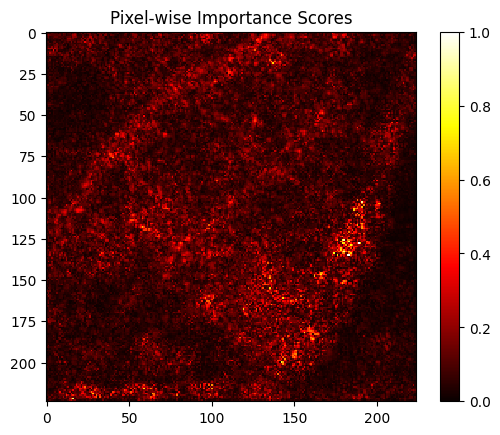

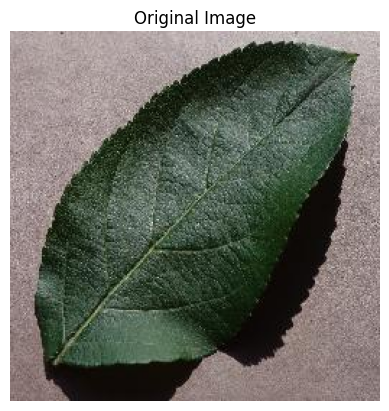

In [4]:
# Importing necessary libraries for gradient computation and visualization
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Define function to preprocess an image from a file path
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor

# Prepare the VGG-16 model for gradient calculation
model.eval()  # Ensure the model is in evaluation mode

# Select a sample image for analysis (e.g., the first image from the test set)
sample_image_path = df['image_path'][0]
sample_image_label = df['label'][0]

# Get the preprocessed image tensor
sample_image_tensor = preprocess_image(sample_image_path)

# Enable gradient computation for the image tensor
sample_image_tensor.requires_grad = True

# Forward pass to get the features
features = model(sample_image_tensor)

# Compute the projection of the features on the direction vector w
projection = torch.dot(features.flatten(), torch.tensor(w, dtype=torch.float32))

# Backward pass to compute the gradients
projection.backward()

# Get the gradients with respect to the input image
gradients = sample_image_tensor.grad.data.numpy().squeeze()

# Compute the importance scores (square norm of the gradients across the RGB channels)
importance_scores = np.linalg.norm(gradients, axis=0)

# Normalize the importance scores to the range [0, 1] for visualization
importance_scores = (importance_scores - importance_scores.min()) / (importance_scores.max() - importance_scores.min())

# Visualize the importance scores as a heatmap
plt.imshow(importance_scores, cmap='hot', interpolation='nearest')
plt.title('Pixel-wise Importance Scores')
plt.colorbar()
plt.show()

# Display the original image for comparison
original_image = Image.open(sample_image_path)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.show()


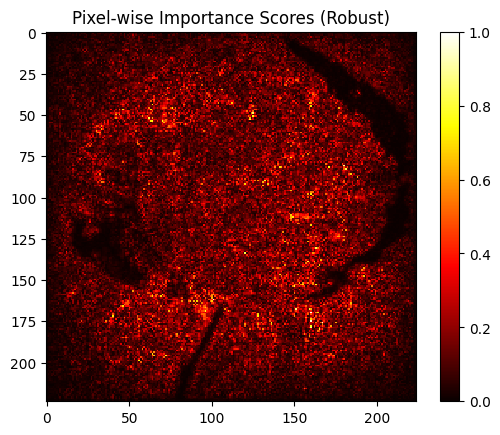

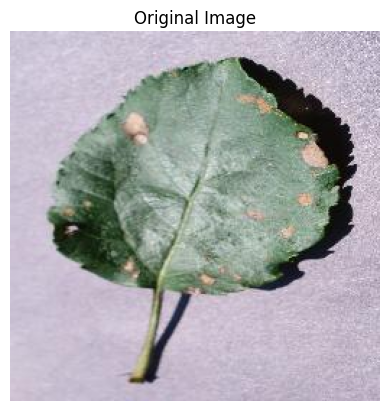

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class BiasedLayer(nn.Module):
    def __init__(self, original_layer):
        super(BiasedLayer, self).__init__()
        self.original_layer = original_layer
        self.weight = nn.Parameter(original_layer.weight.data.clone())
        self.bias = nn.Parameter(original_layer.bias.data.clone())

    def forward(self, x):
        w_bias = self.weight + 0.25 * torch.clamp(self.weight, min=0)
        b_bias = self.bias + 0.25 * torch.clamp(self.bias, min=0)
        if isinstance(self.original_layer, nn.Conv2d):
            out = F.conv2d(x, w_bias, b_bias, self.original_layer.stride, self.original_layer.padding)
        elif isinstance(self.original_layer, nn.Linear):
            out = F.linear(x, w_bias, b_bias)
        return out

def replace_with_biased_layers(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            setattr(model, name, BiasedLayer(module))
        elif isinstance(module, nn.Sequential):
            for sub_name, sub_module in module.named_children():
                if isinstance(sub_module, nn.Linear) or isinstance(sub_module, nn.Conv2d):
                    setattr(module, sub_name, BiasedLayer(sub_module))
                else:
                    replace_with_biased_layers(sub_module)
        else:
            replace_with_biased_layers(module)

# Apply the biased layer replacement to the VGG-16 model (excluding the first and last layers)
model_with_biased_layers = models.vgg16(weights=weights)
replace_with_biased_layers(model_with_biased_layers.features)
replace_with_biased_layers(model_with_biased_layers.classifier)

# Select a sample image from the "apple-black-rot" class for analysis
diseased_image_path = df[df['label'] == 'apple-black-rot']['image_path'].iloc[0]

# Preprocess the sample image
sample_image_tensor = preprocess_image(diseased_image_path)
sample_image_tensor.requires_grad = True

# Forward pass to get the features
features = model_with_biased_layers(sample_image_tensor)

# Flatten the features
features_flattened = features.view(features.size(0), -1)

# Ensure w has the same dimension as the flattened features
w_resized = np.resize(w, features_flattened.shape[1])

# Compute the projection of the features on the direction vector w
projection = torch.dot(features_flattened.squeeze(), torch.tensor(w_resized, dtype=torch.float32))

# Backward pass to compute the gradients
projection.backward()

# Get the gradients with respect to the input image
gradients = sample_image_tensor.grad.data.numpy().squeeze()

# Compute the importance scores (square norm of the gradients across the RGB channels)
importance_scores = np.linalg.norm(gradients, axis=0)

# Normalize the importance scores to the range [0, 1] for visualization
importance_scores = (importance_scores - importance_scores.min()) / (importance_scores.max() - importance_scores.min())

# Visualize the importance scores as a heatmap
plt.imshow(importance_scores, cmap='hot', interpolation='nearest')
plt.title('Pixel-wise Importance Scores (Robust)')
plt.colorbar()
plt.show()

# Display the original image for comparison
original_image = Image.open(diseased_image_path)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.show()
